In [1]:
import os 
os.chdir(r'D:\churn prediction')

In [35]:
from src.training_model import train_model_pipeline
import xgboost
import pandas as pd
import numpy as np
from src.preprocessing import preprocessing_pipeline
from src.training_model import train_model_pipeline
from src.metrics import metrics_evaluation,validation_evalution
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
import pickle

In [3]:
train = pd.read_csv(r'D:\churn prediction\data\fe_train.csv')
test =  pd.read_csv(r'D:\churn prediction\data\fe_test.csv')

In [4]:
X_train = train.drop(columns='Churn')
y_train = train['Churn']

X_test = test.drop(columns='Churn')
y_test = test['Churn']

In [5]:
num_cols = X_train.select_dtypes([int,float]).columns
cat_cols = X_train.select_dtypes([object]).columns
tnf = preprocessing_pipeline(num_cols,cat_cols)

### baseline model metrics

In [6]:
load_results()

,model,recall_test,precision_test,recall_train,precision_train
0,baseline_xgboost,0.831579,0.752381,0.853093,0.789976
1,RandomForestClassifier,0.873684,0.988095,0.863402,0.988201
2,GradientBoostingClassifier,0.873684,0.988095,0.868557,1.000000
3,XGBClassifier,0.873684,0.976471,0.863402,0.991124


# Random Forest

In [28]:
rf = RandomForestClassifier(
            random_state=42,
            max_depth=7,
            min_samples_split=14,
            class_weight='balanced',
            max_samples= 0.81,
            max_features=0.45,
            n_estimators=176
            
        )
rf_model = train_model_pipeline(rf,tnf,X_train,y_train)

In [29]:
validation_evalution(rf_model,'recall',X_train,y_train)

np.float64(0.8582750582750582)

In [30]:
validation_evalution(rf_model,'precision',X_train,y_train)

np.float64(0.9881847990032133)

Train metrics
recall: 0.863
precision:0.988
 
Test metrics
recall: 0.874
precision:0.988


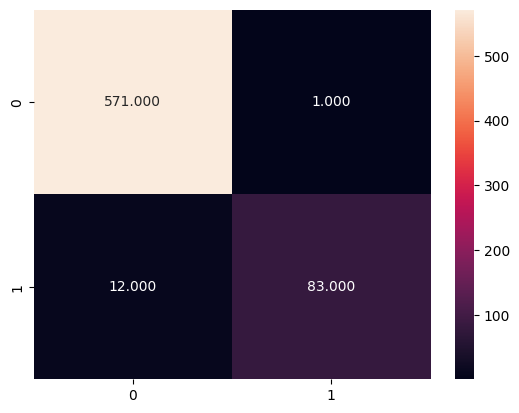

In [31]:
metrics_evaluation(rf_model,X_train,X_test,y_train,y_test)

In [32]:
#save results
#save_results(rf_model,'RandomForestClassifier',X_train,X_test,y_train,y_test)

In [33]:
load_results()

,model,recall_test,precision_test,recall_train,precision_train
0,baseline_xgboost,0.831579,0.752381,0.853093,0.789976
1,RandomForestClassifier,0.873684,0.988095,0.863402,0.988201
2,GradientBoostingClassifier,0.873684,0.988095,0.868557,1.000000
3,XGBClassifier,0.873684,0.976471,0.863402,0.991124


In [38]:
pickle.dump(rf_model,open(r'D:\churn prediction\models\rf_model.pkl','wb'))

# Gradient Boosting classifier

In [39]:

gb = GradientBoostingClassifier(
            random_state=43,
            max_depth= 4,
            learning_rate=0.06,
            min_samples_split= 6,
            n_estimators= 100,
            max_features= 0.70)

In [40]:
gb_model = train_model_pipeline(gb,tnf,X_train,y_train)

In [41]:
validation_evalution(gb_model,'precision',X_train,y_train)

np.float64(0.9939393939393939)

Train metrics
recall: 0.869
precision:1.000
 
Test metrics
recall: 0.874
precision:0.988


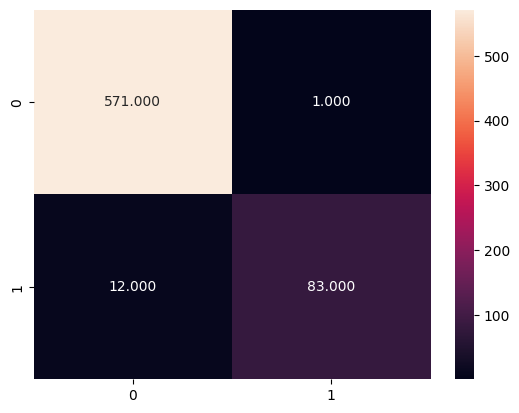

In [42]:
metrics_evaluation(gb_model,X_train,X_test,y_train,y_test)

In [43]:
#save_results(gb_model,'GradientBoostingClassifier',X_train,X_test,y_train,y_test)

In [44]:
load_results()

,model,recall_test,precision_test,recall_train,precision_train
0,baseline_xgboost,0.831579,0.752381,0.853093,0.789976
1,RandomForestClassifier,0.873684,0.988095,0.863402,0.988201
2,GradientBoostingClassifier,0.873684,0.988095,0.868557,1.000000
3,XGBClassifier,0.873684,0.976471,0.863402,0.991124


In [45]:
pickle.dump(gb_model,open('D:\churn prediction\models\gb_model.pkl','wb'))

# XGBOOST

In [46]:
import optuna
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score,StratifiedKFold

def objective(trial):
    
    max_depth = trial.suggest_int('max_depth',3,20)
    eta= trial.suggest_float('eta',0.1,3)
    scale_pos_weight = trial.suggest_float('scale_pos_weight',2.0,7.0)
    subsample  = trial.suggest_float('subsample',0.6,0.9)
    colsample_bytree = trial.suggest_float('colsample_bytree',0.6,0.9)
    n_estimators = trial.suggest_int('n_estimators',50,200)
    reg_alpha=trial.suggest_float('reg_alpha', 0.0, 1.0)
   
    pipe = Pipeline([
        
        ('tnf',tnf),
       ('model',XGBClassifier(
            random_state=42,
            max_depth = max_depth,
            eta = eta,
            scale_pos_weight = scale_pos_weight ,
            subsample  = subsample ,
            colsample_bytree = colsample_bytree ,
            n_estimators = n_estimators ,
            reg_alpha = reg_alpha,
           
           
             
       ))
    ])

    
    cv =  StratifiedKFold(n_splits=3,shuffle=True)
    cv_result = cross_val_score(pipe,X_train,y_train,cv=cv,scoring='recall',)
    return np.mean(cv_result)

In [20]:
#study = optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler())
#study.optimize(objective,n_trials=200)

#study.best_value

In [47]:
xgb = xgboost.XGBClassifier(max_depth=3,eta=0.09,scale_pos_weight=4.5,n_estimators=100,random_state=42)
xgb_model = train_model_pipeline(xgb,tnf,X_train,y_train)

Train metrics
recall: 0.863
precision:0.991
 
Test metrics
recall: 0.874
precision:0.976


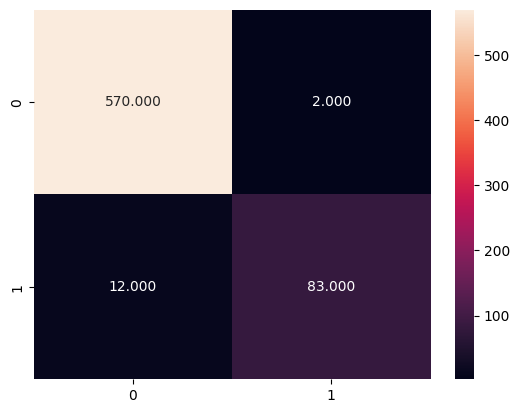

In [48]:
metrics_evaluation(xgb_model,X_train,X_test,y_train,y_test)

In [49]:
validation_evalution(xgb_model,'precision',X_train,y_train)

np.float64(0.9703911526198187)

In [50]:
validation_evalution(xgb_model,'recall',X_train,y_train)

np.float64(0.8479520479520479)

In [25]:
#save_results(xgb_model,'XGBClassifier',X_train,X_test,y_train,y_test)

In [51]:
load_results()

,model,recall_test,precision_test,recall_train,precision_train
0,baseline_xgboost,0.831579,0.752381,0.853093,0.789976
1,RandomForestClassifier,0.873684,0.988095,0.863402,0.988201
2,GradientBoostingClassifier,0.873684,0.988095,0.868557,1.000000
3,XGBClassifier,0.873684,0.976471,0.863402,0.991124


In [54]:
pickle.dump(xgb_model,open(r'D:\churn prediction\models\final_model.pkl','wb'))

# ROC AUC 

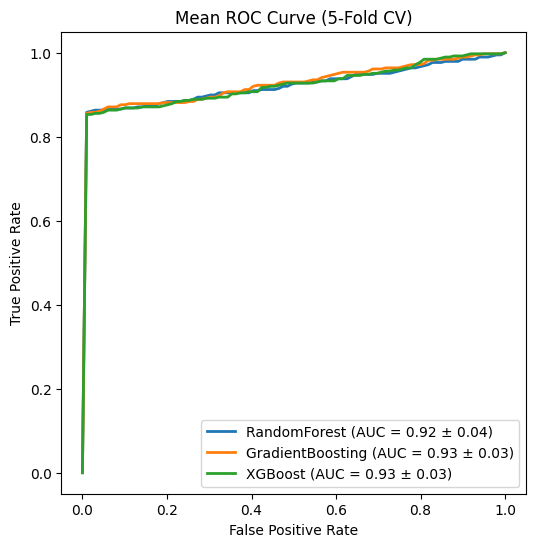

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

all_models = [rf, gb, xgb]
model_names = ['RandomForest', 'GradientBoosting', 'XGBoost'] 

cv = StratifiedKFold(n_splits=5)
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))

for model, name in zip(all_models, model_names):
    classifier = Pipeline([
        ('tnf', tnf),
        ('model', model)
    ])
    tprs = []
    aucs = []
    for train_idx, test_idx in cv.split(X_train, y_train):
        classifier.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
        y_prob = classifier.predict_proba(X_train.iloc[test_idx])[:, 1]
        fpr, tpr, _ = roc_curve(y_train.iloc[test_idx], y_prob)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr, tpr))

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    ax.plot(mean_fpr, mean_tpr, lw=2,
            label=f"{name} (AUC = {mean_auc:.2f} ± {std_auc:.2f})")

ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate',
       title='Mean ROC Curve (5-Fold CV)')
ax.legend(loc='lower right')
plt.show()

XGBoost outperformed both Random Forest and Gradient Boosting across all evaluation metrics and is therefore selected as the final model.